# **Minimum Wage in the European Union**

<figure>
    <img src="./imgs/eu_flag.jpeg" alt="Flag">
</figure> 

## **Overview**

Effectiveness and opportunity of a law-established miminum wage is an opened debate
Actually, there some pros and cons arguments on which researchers, politicians and social parts discuss, being unable to meet on some agreements:
Pros:
- minimum wage is mean to gain social equity
- can improve overall life quality on lower social classes
- lead to a fairier labour market, giving more power to weaker counterparts
- fix distortions of the "gig economy", enhancing employers with farier hiring policies 

Cons:
- raises labour cost, leading to raising unemplyoment
- for the same reason, leads to higher inflation 
- promotes undeclare work
- disincentives foreign investments

Some resources can help in overviewing the debate:

- https://minimum-wage.procon.org/
- https://www.nber.org/system/files/working_papers/w18681/w18681.pdf

## **Objectives**

Objective of the present work is to provide some insights based on available data to address some of the questions heades in the *Overview* section. For the scope of this analysis, we concentrate on data relative to the **European Union**
In particular, we want to investigate:

1. How is minumum wage distributed in the EU? Which countries have a minimum wage and what's the proportion to the overall wage level? How is it changing over time?
2. Is there any association between presence/absence of minimum wage and other labour market (unemployment rate) and economic indicators (GDP)?
3. In the coutries where minumum wage is present, can we find any association between minimum wage level and other indicators?



## **Methodology**

The data needed for the analysis are gathered from [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database)
We downloaded the following datasets
- Population data: Population on 1 January by age and sex group
- Labour market: Unemployment by sex and age - annual data
- Macro economic indicators: GDP and main components
- Minimum wage: Monthly minimum wage as a proportion of average monthly earnings (%)
- Geolocation data (https://ec.europa.eu/eurostat/web/gisco/)

### Data collection

We use the Python programming language and some spetialized package for collecting and downloading the data  

### Data cleaning and ingestion

We use Python's *pandas* module for data cleaning and reshaping
After that, we store cleaned data on PostgreSQL data base. This is going to be the common data repository for either the *analysis* phase and the *sharing* phase

### Analysis

For analysis, we leverage:
- Python's *pandas* and *statsmodels* for descriptive statistics and hypothesis testing
- Python's *plotly* for data visualization 

### Sharing 

We use *Tableau Public* to provide sharable and interactive visalization for the interested audience 

## **References**

Eurostat web site: https://ec.europa.eu/eurostat/web/main/data/database

In [28]:
%config Completer.use_jedi = False

In [55]:
#required libraries
import requests as rq
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import json
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Constants

In [30]:
# Codes of countries
COUNTRY_CODES = ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 
                 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 'LV', 'ME', 'MK', 
                 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UK']
# Basic URL of Eurostat's Web Services
BASEURL = "http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/"

## Geolocation data

In [31]:
geo_orig = gpd.read_file('zip:///home/michele/MINWAGE/data/CNTR_RG_60M_2020_4326.shp.zip')

countries_df = geo_orig.drop(["CNTR_NAME", "ISO3_CODE", "FID"], axis=1).rename({'CNTR_ID':'country_code','NAME_ENGL':'name'}, axis=1)
countries_df = countries_df[countries_df.country_code.isin(COUNTRY_CODES)]

## Helper function: download data via Eurostat Web Service and build a pandas df in long-form

In [32]:

def build_df(url_request, measure_name='measure', base_url=BASEURL, value='value'):
    '''
    Download dataset from Eurostat Web Service and builds a pandas dataframe in long-form
    returns: pandas.DataFrame
    '''
    result = rq.get(BASEURL+url_request)
    if result.status_code != 200:
        return None
    
    j = result.json()
    countries = j['dimension']['geo']['category']['index']
    years = j['dimension']['time']['category']['index']
    values_df = pd.DataFrame(zip(j[value].keys(), j[value].values()),columns=['id',measure_name])
    ## build features dict as DF
    feat_df = pd.DataFrame(columns=['id','year','country_code'])
    i = 0
    for c in countries.items():
        for y in years.items():
            row_dict = {}
            row_dict['id'] = str(i)
            row_dict['year'] = y[0]
            row_dict['country_code'] = c[0]
            feat_df = feat_df.append(row_dict, ignore_index = True)
            i+=1
    final_df = pd.merge(feat_df, values_df, on='id', how='left')
    final_df = final_df[final_df.country_code.isin(COUNTRY_CODES)].drop(['id'],axis=1)
    
    return final_df

## Minimum wage

In [33]:
url_request = "earn_mw_avgr2?sinceTimePeriod=2005&precision=1&unit=PC&shortLabel=1&indic_se=MMW_MEAN_ME_PP&nace_r2=B-S"

In [34]:
minwage_df = build_df(url_request, 'min_wage_prop')

#### for minimum wage, additional calculation has to be performed in order to determine which countries have min wage

In [35]:
check_mw_df = build_df(url_request, measure_name='status', value='status')
check_mw_df = check_mw_df.fillna(':zz')

mw_countries_df = check_mw_df.groupby('country_code').max()[['status']].reset_index().replace({':zz':'Yes', ':z':'No', ':':'No'}).rename({'status':'has_min_wage'},axis=1)

In [36]:
countries_df = countries_df.merge(mw_countries_df,how='left',on='country_code')

## GDP

In [37]:
url_request = "nama_10_gdp?na_item=B1GQ&sinceTimePeriod=2005&precision=1&unit=CP_MEUR&shortLabel=1"

In [38]:
gdp_df = build_df(url_request, 'gdp')

## Unemployment

In [39]:
url_request = "une_rt_a?sinceTimePeriod=2005&precision=1&sex=T&unit=PC_ACT&shortLabel=1&age=Y15-74"

In [40]:
unmp_df = build_df(url_request, 'unemployment_rate')

## Population

In [41]:
url_request = "demo_pjan?sinceTimePeriod=2005&precision=1&sex=T&shortLabel=1&age=TOTAL"

In [42]:
pop_df = build_df(url_request, 'population')

## Load data into PostreSQL db

DB Diagram:
<figure>
    <img src="./imgs/ER_diagram.png" alt="ER">
</figure>

In [43]:
with open('data/connection.json', 'r') as f:
    conn_data = json.load(f)

In [44]:
pg_connstring = 'postgresql://'+conn_data['connection']['user']+ \
                ':'+conn_data['connection']['password']+ \
                '@'+conn_data['connection']['server']+ \
                ':'+conn_data['connection']['port']+ \
                '/'+conn_data['connection']['db']

In [45]:
engine = create_engine(pg_connstring)

In [46]:
countries_to_insert = countries_df.copy()
countries_to_insert['geometry'] = countries_to_insert['geometry'].apply(lambda x: wkt.dumps(x))

In [47]:
conn = engine.connect()
try: 
    conn.execute("BEGIN TRANSACTION")
    conn.execute("TRUNCATE TABLE gdp, minimum_wage, population, unemployment, countries")
    countries_to_insert.to_sql('countries', engine, if_exists='append', index=False)
    gdp_df.to_sql('gdp', engine, if_exists='append', index=False)
    minwage_df.to_sql('minimum_wage', engine, if_exists='append', index=False)
    pop_df.to_sql('population', engine, if_exists='append', index=False)
    unmp_df.to_sql('unemployment', engine, if_exists='append', index=False)
    conn.execute("COMMIT")
    print('data successfully loaded to db')
except:
    conn.execute("ROLLBACK")
    print('unable to load data to db')
    raise
finally:
    conn.close()

data successfully loaded to db


## Analysis

### Trend over time

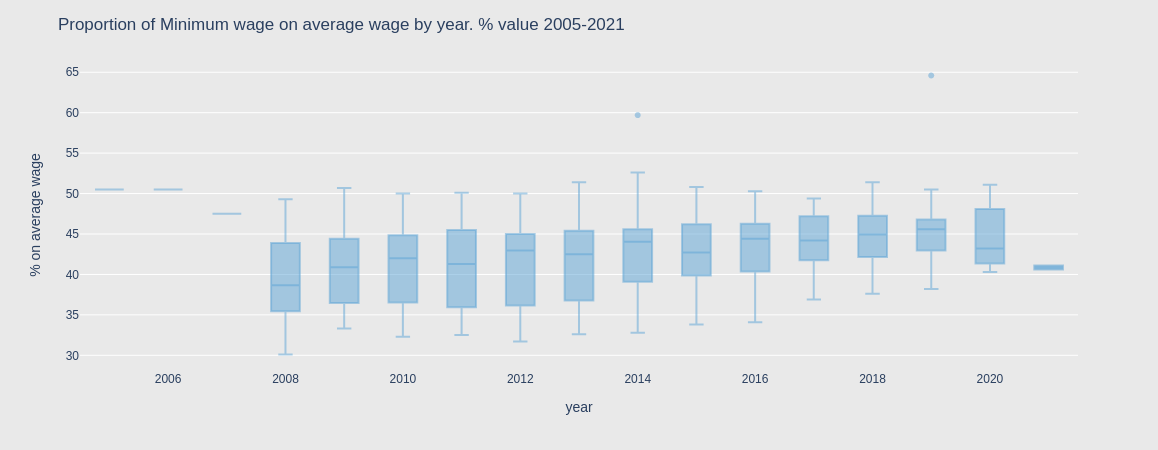

In [48]:
fig = px.box(minwage_df, x='year', y='min_wage_prop')
fig.update_layout(
    title='Proportion of Minimum wage on average wage by year. % value 2005-2021',
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
    yaxis={'title':'% on average wage'}
)
fig.update_traces(marker_color='rgba(93, 164, 214, 0.5)')
fig.show()

### Analysis by Country

In [49]:
avg_min_wage_by_country = countries_df.join(minwage_df.groupby('country_code').agg(['min','max','mean'])["min_wage_prop","mean"],how='right',on='country_code')

avg_min_wage_by_country.columns = list(countries_df.columns) + ['avg_min_wage']

/home/michele/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)



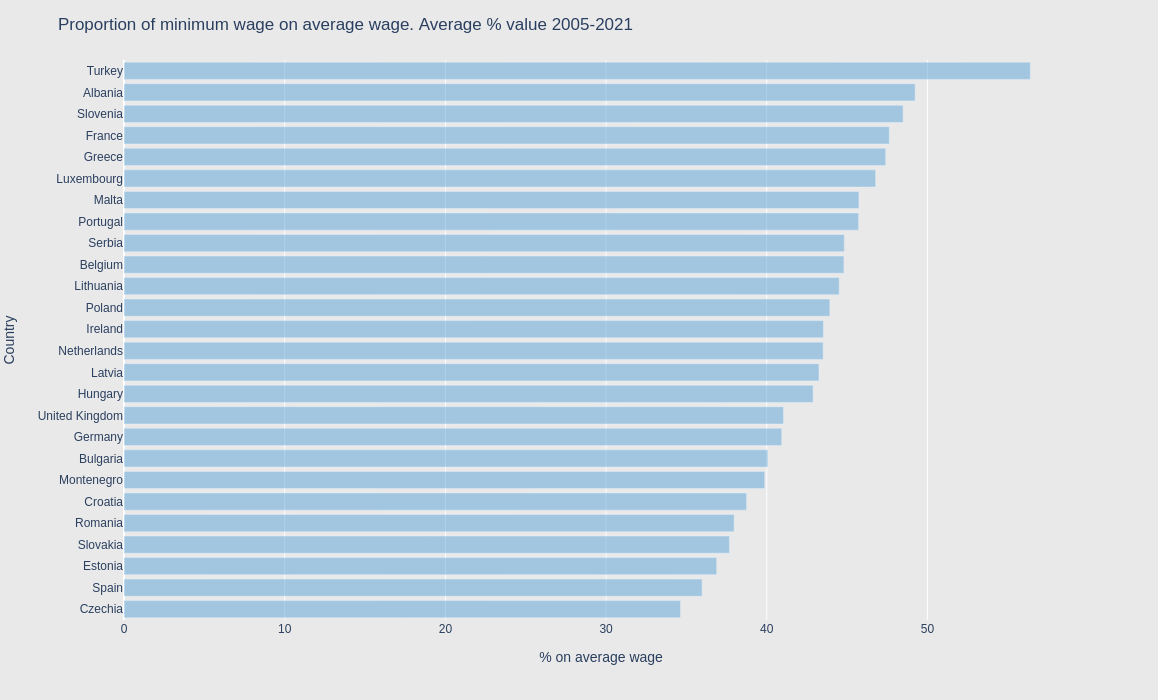

In [50]:
fig = px.bar(avg_min_wage_by_country.dropna(), 
             y='name', 
             x='avg_min_wage', 
             orientation='h'
            )
fig.update_layout(title='Proportion of minimum wage on average wage. Average % value 2005-2021',
                  height=700, 
                  yaxis={'categoryorder':'total ascending','title':'Country'}, 
                  xaxis={'title':'% on average wage'},
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgb(233,233,233)',
                 )
fig.update_traces(marker_color='rgba(93, 164, 214, 0.5)')
fig.show()

In [53]:
# filter to exclude extra continental territoires
MINLON = -25
MAXLON = 50
MINLAT = 33
MAXLAT = 73

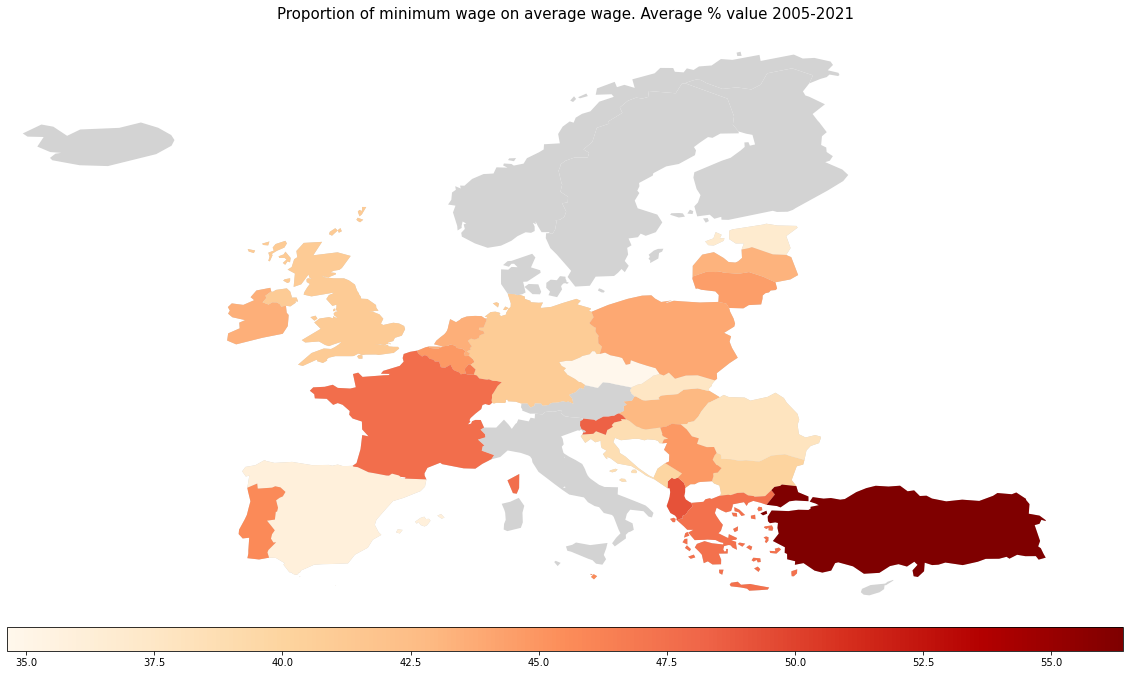

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="4%", pad=0.1)
avg_min_wage_by_country.plot(color='lightgrey',
                             ax=ax)
avg_min_wage_by_country.plot(column='avg_min_wage', 
                             ax=ax, 
                             cmap='OrRd',
                             legend=True,
                             legend_kwds={'orientation':'horizontal'},
                             cax=cax)

ax.set_xlim(MINLON, MAXLON)
ax.set_ylim(MINLAT, MAXLAT)
ax.axis('off')
ax.set_title("Proportion of minimum wage on average wage. Average % value 2005-2021", fontdict={'fontsize':15});